In [2]:
import tensorflow as tf  # 引入tensorflow库
from tensorflow.examples.tutorials.mnist import input_data  # 载入minist数据集

mnist = input_data.read_data_sets(
    "MNIST_data/", one_hot=True, source_url="http://storage.googleapis.com/cvdf-datasets/mnist/")

images_train = mnist.train.images
images_test = mnist.test.images
labels_train = mnist.train.labels
labels_test = mnist.test.labels


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


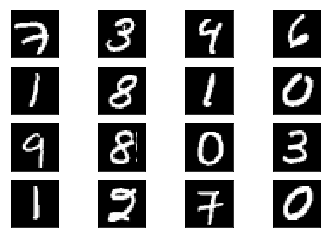

In [4]:
import matplotlib.pyplot as plt
import numpy as np

f, axarr = plt.subplots(4, 4)

for n, ax in enumerate(axarr.flat):
    ax.imshow(np.reshape(images_train[n], (28, 28)), cmap='gray', interpolation='nearest')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

plt.show()

In [5]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, 784], name="x")
y = tf.placeholder(tf.float32, shape=[None, 10], name="y")


In [6]:
W = tf.get_variable(name="W", shape=[784, 10], initializer=tf.truncated_normal_initializer(), dtype='float32')
b = tf.get_variable(name="b", shape=[10], initializer=tf.truncated_normal_initializer(0), dtype='float32')

In [7]:
y_pred = tf.nn.softmax(tf.matmul(x, W) + b, name="y_pred") 

In [8]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_pred), reduction_indices=[1]), name="cross_entropy")

loss = cross_entropy + 1e-7 * tf.nn.l2_loss(W)

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_pred, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [9]:
learning_rate = 0.05

train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [10]:
from datetime import datetime

now = datetime.utcnow().isoformat()
logdir = "./%s/" % now

cross_entropy_summary = tf.summary.scalar('cross_entropy', cross_entropy)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

accuracies = []
epoch = 80000
batch_size = 100

saver = tf.train.Saver()
best_accuracy = 0.

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    for i in range(epoch):
        start_index = i * batch_size % images_train.shape[0]
        batch_x = images_train[start_index: start_index + batch_size, :]
        batch_y = labels_train[start_index: start_index + batch_size, :]
        
        if i % 100 == 0:
            summary_str = sess.run(cross_entropy_summary, feed_dict={
                x: batch_x,
                y: batch_y,
            })
            file_writer.add_summary(summary_str, i)

        _cross_entropy, _ = sess.run(
            [cross_entropy, train_step],
            feed_dict={
                x: batch_x,
                y: batch_y,
            }
        )
        if i % 100 == 0:
            _accuracy = sess.run(
                accuracy,
                feed_dict={
                    x: images_test,
                    y: labels_test,
                }
            )
            if _accuracy > best_accuracy:
                saver.save(sess, "./best_model.ckpt")
            if i % 1000 == 0:
                print("After %s epoch, accuracy = %.4f" % (i, _accuracy))
            accuracies.append(_accuracy)

plt.plot(range(len(accuracies)), accuracies)
plt.xlabel('iter')
plt.ylabel('accuracy')
plt.show()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
After 0 epoch, accuracy = 0.1258
After 1000 epoch, accuracy = 0.7561
After 2000 epoch, accuracy = 0.8180
After 3000 epoch, accuracy = 0.8422
After 4000 epoch, accuracy = 0.8565
After 5000 epoch, accuracy = 0.8656
After 6000 epoch, accuracy = 0.8709


KeyboardInterrupt: 

In [73]:
with tf.Session() as sess:
    saver.restore(sess, "./best_model.ckpt")
    _accuracy = sess.run(
        accuracy,
        feed_dict={
            x: images_test,
            y: labels_test,
        }
    )
    print('model accuracy is: %s' % _accuracy)

INFO:tensorflow:Restoring parameters from ./best_model.ckpt
model accuracy is: 0.9166


In [11]:
from datetime import datetime

now = datetime.utcnow().isoformat()
logdir = "./%s/" % now

cross_entropy_summary = tf.summary.scalar('cross_entropy', cross_entropy)
accuracy_summary = tf.summary.scalar('accuracy', accuracy)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

epoch = 80000
batch_size = 100

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    for i in range(epoch):
        start_index = i * batch_size % images_train.shape[0]
        batch_x = images_train[start_index: start_index + batch_size, :]
        batch_y = labels_train[start_index: start_index + batch_size, :]

        _cross_entropy, _ = sess.run(
            [cross_entropy, train_step],
            feed_dict={
                x: batch_x,
                y: batch_y,
            }
        )
        if i % 100 == 0:
            cm_summary_str = sess.run(cross_entropy_summary, feed_dict={
                x: batch_x,
                y: batch_y,
            })
            accuracy_summary_str = sess.run(accuracy_summary, feed_dict={
                x: images_test,
                y: labels_test,
            })
            file_writer.add_summary(cm_summary_str, i)
            file_writer.add_summary(accuracy_summary_str, i)

file_writer.close()